In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
# Define the base directory where the images and captions are stored
BASE_DIR = r'C:\Users\RippleNova\img_VGG16'

# Path to the folder containing the images
IMAGES_DIR = r'C:\Users\RippleNova\img_VGG16\dataset\ficker8k_images'

# Path to the captions file
CAPTIONS_FILE = r'C:\Users\RippleNova\img_VGG16\dataset\captions.txt'

# Path to the working directory where model outputs, logs, etc. will be saved
WORKING_DIR = r'C:\Users\RippleNova\img_VGG16\model'

In [3]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
features = {}

# Preprocess the images and extract features
for img_name in tqdm(os.listdir(IMAGES_DIR)):
    img_path = os.path.join(IMAGES_DIR, img_name)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
# Load captions
with open(CAPTIONS_FILE, 'r', encoding='utf-8') as file:
    captions_doc = file.read()

In [6]:
mapping = {}

# Process captions and map to images
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split('.')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = ' '.join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40455 [00:00<?, ?it/s]

In [8]:
import re

# Cleaning the captions
def clean(mapping):
    for key, captions_list in mapping.items():
        for i in range(len(captions_list)):
            caption = captions_list[i]
            caption = caption.lower()
            caption = re.sub(u'[\u0964\u0951]+', '', caption)
            caption = re.sub(r'[0-9]', '', caption)
            caption = re.sub(u'[\u0966-\u096F]+', '', caption)
            caption = re.sub(r'\s+', ' ', caption).strip()
            caption = 'startseq ' + caption + ' endseq'
            captions_list[i] = caption

clean(mapping)

In [9]:
# Tokenizer and vocabulary size
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

max_length = max(len(caption.split()) for caption in all_captions)

image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.80)
train = image_ids[:split]
test = image_ids[split:]

In [10]:
# Data generator
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

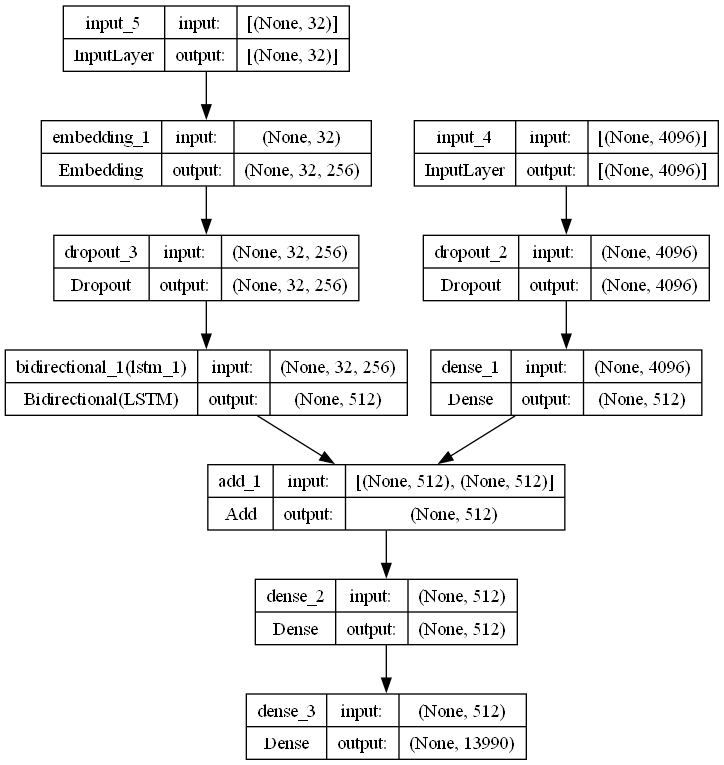

In [12]:
# Building the model with adjusted LSTM size
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
# Adjust LSTM units to 256 to match 512 when bidirectional
se3 = Bidirectional(LSTM(256))(se2)  # 256 units x 2 directions = 512 output

decoder1 = add([fe2, se3])  # Now both shapes are (512,)
decoder2 = Dense(512, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001))

plot_model(model, show_shapes=True)


In [13]:
# Training the model with learning rate reduction
epochs = 30
batch_size = 32
steps = len(train) // batch_size
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=0.00001)

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[reduce_lr])

202/202 [==============================] - 1504s 7s/step - loss: 2.9869 - lr: 1.0000e-04


In [14]:
model.save(WORKING_DIR+'/model2.h5')

C:\Users\RippleNova\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
# Prediction helper functions
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [16]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

In [17]:
# BLEU score evaluation
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
smooth = SmoothingFunction().method4

actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smooth))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth))

  0%|          | 0/1619 [00:00<?, ?it/s]

BLEU-1: 0.457674
BLEU-2: 0.250978
BLEU-3: 0.143662
BLEU-4: 0.078907


In [25]:
pip install pillow

Randomly selected image: 3271061953_700b96520c.jpg
-----PREDICTED CAPTION-----
startseq jpg मानिसहरूको समूह र ट्रकको अगाडि ट्रकको अगाडि बसिरहेका छन् endseq


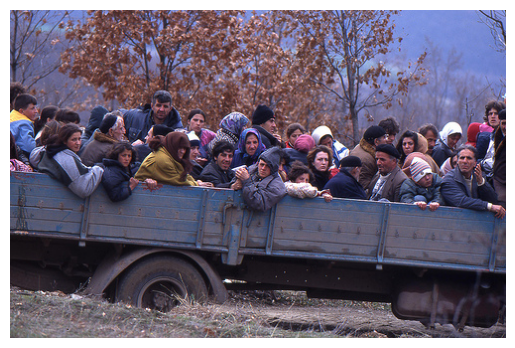

Randomly selected image: 1457762320_7fe121b285.jpg
-----PREDICTED CAPTION-----
startseq jpg साइकल यात्रीहरूको समूह endseq


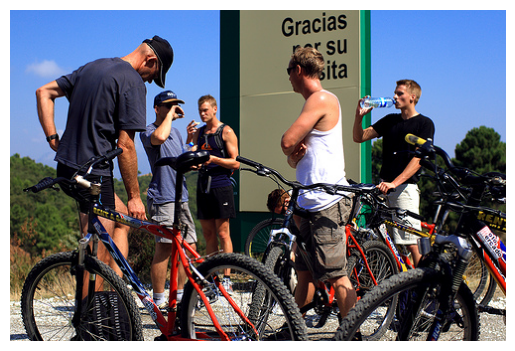

Randomly selected image: 2881087519_ca0aa79b2b.jpg
-----PREDICTED CAPTION-----
startseq jpg एक साइकल सवार गरेको साइकल चलाउँदै endseq


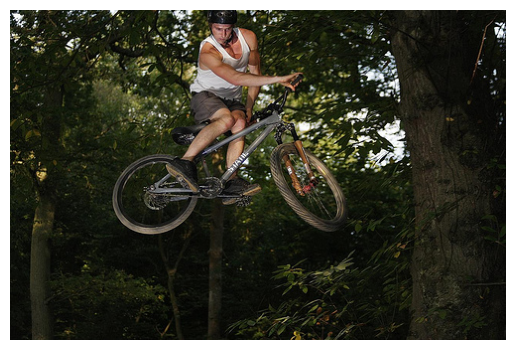

In [27]:
import random
from PIL import Image
import matplotlib.pyplot as plt

def generate_random_caption():
    # Get a list of all image filenames in IMAGES_DIR
    image_list = os.listdir(IMAGES_DIR)
    
    # Randomly select an image from the directory
    image_name = random.choice(image_list)
    
    # Get image ID (without file extension)
    image_id = image_name.split('.')[0]
    
    # Construct the image path using IMAGES_DIR
    image_path = os.path.join(IMAGES_DIR, image_name)
    
    # Open and display the image using PIL
    image = Image.open(image_path)
    
    # Generate the predicted caption (assuming 'predict_caption' function exists)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    
    # Display the predicted caption
    print(f'Randomly selected image: {image_name}')
    print('-----PREDICTED CAPTION-----')
    print(y_pred)
    
    # Show the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Hide axes for a cleaner display
    plt.show()

# Call the function after training to see random image caption generation
generate_random_caption()
generate_random_caption()
generate_random_caption()
